In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from random import sample
from collections import defaultdict
import graphviz 
import pandas

print('Loaded imports')

Loaded imports


In [2]:
# h1b_df = pandas.read_csv('../data/h1b.csv')
perm_df = pandas.read_csv('../data/perm.csv', thousands=",")
housing_df = pandas.read_csv('../data/housing.csv')

# h1b_df = h1b_df[['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE', 'CASE_STATUS']]
perm_df = perm_df[['naics_2007_us_code', 'wage_offer_from_9089', 'case_status', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'pw_level_9089']]
housing_columns = ['MSSubClass', 'LotArea', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'ExterCond', 'CentralAir', 'YrSold']
housing_df = housing_df[housing_columns + ['SalePrice']]

# h1b_df = h1b_df.sample(n=100000)
print('Loaded dataframes')

/Users/philip/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,3,4,5,6,7,10,11,16,17,20,21,22,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,41,42,43,44,45,47,48,49,50,51,52,53,55,56,57,58,59,60,61,63,64,65,66,68,69,70,71,72,73,74,77,79,80,81,82,83,84,85,86,87,88,89,90,92,93,94,95,100,101,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,153) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Loaded dataframes


In [21]:
# format data
datasetNum = 1

df = None
df_x = None
df_y = None
to_encode = []

classifed_names = None

if datasetNum == 0:
    df = h1b_df.copy()
    df_x = ['FULL_TIME_POSITION', 'YEAR', 'PREVAILING_WAGE']
    df_y = 'CASE_STATUS'
elif datasetNum == 1:
    df = perm_df.copy()
    df_x = [
        'wage_offer_from_9089',
        'naics_2007_us_code', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'employer_state', 'pw_level_9089']
    df_y = 'case_status'
    to_encode = [ 'country_of_citzenship', 'employer_state', 'pw_level_9089']
elif datasetNum == 2:
    df = housing_df.copy()
    df_x = housing_columns
    df_y = 'price_bracket'
    to_encode = housing_columns
    
le = preprocessing.LabelEncoder
encoderDict = defaultdict(le)

for column in to_encode:
    print('Encoding: ' + column)
    df[column] = df[column].dropna()
    df = df[df[column].notnull()]
    df[column] = encoderDict[column].fit_transform(df[column])
    print(encoderDict[column].classes_)

if datasetNum == 0:
#     df['CITY'], df['STATE'] = df['WORKSITE'].str.split(',', 1).str
#     df['STATE'] = df['STATE'].str.strip()
#     df['STATE'].apply(str)

    df.loc[(df['FULL_TIME_POSITION'] == 'Y'), 'FULL_TIME_POSITION'] = 1
    df.loc[(df['FULL_TIME_POSITION'] == 'N'), 'FULL_TIME_POSITION'] = -1
    
    df = df[~df['CASE_STATUS'].str.contains("WITHDRAWN", na=True)]
    df = df[~df['CASE_STATUS'].str.contains("PENDING")]
    df = df[~df['CASE_STATUS'].str.contains("INVALIDATED")]
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'CERTIFIED-WITHDRAWN'), 'CASE_STATUS'] = 1
    df.loc[(df['CASE_STATUS'] == 'DENIED'), 'CASE_STATUS'] = -1
    df.loc[(df['CASE_STATUS'] == 'REJECTED'), 'CASE_STATUS'] = -1
    
elif datasetNum == 1:
    df = df[~df['case_status'].str.contains("Withdrawn", na=False)]
    df.loc[(df['case_status'].str.contains('Certified', na=False)), 'case_status'] = 1
    df.loc[(df['case_status'].str.contains('Denied', na=False)), 'case_status'] = -1
    
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('yr', na=False)), 'wage_offer_unit_of_pay_9089'] = 2
    df.loc[(df['wage_offer_unit_of_pay_9089'].str.contains('hr', na=False)), 'wage_offer_unit_of_pay_9089'] = 1
elif datasetNum == 2:
    df['price_bracket'] = df['SalePrice'].copy().astype(int)
    
    classifed_names = []
    for bracket in range(0, 15):
        # Each bracket worth 75k
        bracket_width = 100000
        price_min = bracket * bracket_width
#         print(str(bracket) +': '+ str(price_min))
        price_max = price_min + bracket_width
        classifed_names.append(str(price_min) + '-' + str(price_max))
        df.loc[(df['SalePrice'] >= price_min), 'price_bracket'] = bracket
    
df = df.apply(lambda x: pandas.to_numeric(x.astype(str).str.replace(',',''), errors='coerce'))

print(df[:3])
# indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
# df = df[indices_to_keep]

print(df_x)
print(df_y)

print(df.columns)
print(df.dtypes)


Encoding: country_of_citzenship
['AFGHANISTAN' 'ALBANIA' 'ANGOLA' 'ARGENTINA' 'ARMENIA' 'AUSTRALIA'
 'AUSTRIA' 'AZERBAIJAN' 'BAHAMAS' 'BAHRAIN' 'BANGLADESH' 'BARBADOS'
 'BELARUS' 'BELGIUM' 'BELIZE' 'BHUTAN' 'BOLIVIA' 'BOSNIA AND HERZEGOVINA'
 'BRAZIL' 'BULGARIA' 'BURKINA FASO' 'BURMA (MYANMAR)' 'CAMBODIA' 'CAMEROON'
 'CANADA' 'CHILE' 'CHINA' 'COLOMBIA' 'COSTA RICA' 'CROATIA' 'CYPRUS'
 'CZECH REPUBLIC' 'DENMARK' 'DOMINICA' 'DOMINICAN REPUBLIC' 'ECUADOR'
 'EGYPT' 'EL SALVADOR' 'ESTONIA' 'ETHIOPIA' 'FIJI' 'FINLAND' 'FRANCE'
 'GAMBIA' 'GEORGIA' 'GERMANY' 'GHANA' 'GREECE' 'GRENADA' 'GUATEMALA'
 'GUINEA' 'GUYANA' 'HAITI' 'HONDURAS' 'HONG KONG' 'HUNGARY' 'ICELAND'
 'INDIA' 'INDONESIA' 'IRAN' 'IRAQ' 'IRELAND' 'ISRAEL' 'ITALY' 'IVORY COAST'
 'JAMAICA' 'JAPAN' 'JORDAN' 'KAZAKHSTAN' 'KENYA' 'KOSOVO' 'KUWAIT'
 'KYRGYZSTAN' 'LAOS' 'LATVIA' 'LEBANON' 'LESOTHO' 'LIBERIA' 'LIBYA'
 'LITHUANIA' 'MACEDONIA' 'MALAYSIA' 'MALI' 'MALTA' 'MAURITIUS' 'MEXICO'
 'MOLDOVA' 'MONGOLIA' 'MOROCCO' 'NEPAL' 'NETHERLAND

In [4]:
df = df.dropna()  
# sample = df.sample(n=10000)

# Shuffle
df = df.sample(frac=1).reset_index(drop=True)
print('Dataset size: ' + str(df.size))
print('Features: ' + str(df_x))
print('Trying to classify: ' + df_y)

X = df.loc[:, df_x]
y = df.loc[:, df_y]

trainTest = train_test_split(X, y, test_size=0.1, train_size=0.9, random_state=0)
print('hi')

Dataset size: 127652
Features: ['wage_offer_from_9089', 'naics_2007_us_code', 'wage_offer_unit_of_pay_9089', 'country_of_citzenship', 'employer_state', 'employer_state', 'pw_level_9089']
Trying to classify: case_status
hi


In [70]:
from sklearn.model_selection import GridSearchCV, learning_curve
from datetime import datetime

cross_validations = 4
train_sizes_base = [50, 60, 80, 100, 125, 150, 200, 300, 400, 500, 600, 700, 800]

def plot_learning_curve(title, base_curve, cv_curve):
    _, _, test_scores_base = base_curve
    train_sizes, train_scores, test_scores = cv_curve
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    
    test_scores_base_mean = np.mean(test_scores_base, axis=1)
    test_scores_base_std = np.std(test_scores_base, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.figure()
    plt.title(title)
    plt.ylim((.4, 1.01))
    
    if datasetNum == 1:
        plt.ylim((.55, 1.01))
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    
    plt.fill_between(train_sizes, test_scores_base_mean - test_scores_base_std,
                     test_scores_base_mean + test_scores_base_std, alpha=0.1, color="b")
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_base_mean, 'o-', color="b",
             label="Test Score without CV")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Test Score with CV")

    plt.legend(loc="best")
    return plt

def crossValidateAndTest(name, clf, params, trainTest, scaler=None):
    X_train, X_test, y_train, y_test = trainTest.copy()
    print('Name: ' + name)
    if not scaler is None:
        scaler.fit(X_train) 
        X_train = scaler.transform(X_train)
        X_test = scaler.transform(X_test)
    
    base_clf = GridSearchCV(clf, param_grid=params, refit=True, cv=None)
    cv_clf = GridSearchCV(clf, param_grid=params, refit=True, cv=cross_validations)
    
    base_clf.fit(X_train, y_train)
    
    start = datetime.now()
    cv_clf.fit(X_train, y_train)
    end = datetime.now()
    train_time = (end - start).total_seconds()
    train_score = cv_clf.score(X_train, y_train)
    print('Train time: ' + str(train_time))
    print('Train score: ' + str(train_score))
    
    start = datetime.now()
    test_score = cv_clf.score(X_test, y_test)
    end = datetime.now()
    test_time = (end - start).total_seconds()
    print('Test time: ' + str(test_time))
    print('Test score: ' + str(test_score))
    
    
    
    base_estimator = base_clf.best_estimator_
    cv_estimator = cv_clf.best_estimator_
    
    print("Best params: " + str(cv_clf.best_params_))
    
    table_output = '{:.4f} & {:.4f} & {:.4f} & {:.4f}'.format(train_score, train_time, test_score, test_time)
    
    
    
#     score = optimized_clf.score(X_test, y_test)
     
    additional_sizes = []
    if datasetNum == 1:
        additional_sizes = [1000, 1500, 2000, 2500, 3000]
        
    all_sizes = train_sizes_base + additional_sizes
    base_curve = learning_curve(base_estimator, X_train, y_train, cv=None, train_sizes=all_sizes)
    cv_curve = learning_curve(cv_estimator, X_train, y_train, cv=cross_validations, train_sizes=all_sizes)
    
    plot = plot_learning_curve(name, base_curve, cv_curve)
#     plot.show()

    
    return (cv_estimator, cv_clf, table_output)

print("Finished")

Finished


Name: Decision Tree: 1
Train time: 0.088716
Train score: 0.765720204728
Test time: 0.000756
Test score: 0.777960526316
Best params: {'criterion': 'gini'}
1 & gini & 3 & 0.7657 & 0.0887 & 0.7780 & 0.0008 \\ \hline

Name: Decision Tree: 3
Train time: 0.150029
Train score: 0.677492078967
Test time: 0.000936
Test score: 0.674890350877
Best params: {'criterion': 'gini'}
3 & gini & 15 & 0.6775 & 0.1500 & 0.6749 & 0.0009 \\ \hline

Name: Decision Tree: 5
Train time: 0.215382
Train score: 0.713563246405
Test time: 0.000936
Test score: 0.706688596491
Best params: {'criterion': 'gini'}
5 & gini & 63 & 0.7136 & 0.2154 & 0.7067 & 0.0009 \\ \hline

Name: Decision Tree: 7
Train time: 0.262807
Train score: 0.725566658543
Test time: 0.000942
Test score: 0.719298245614
Best params: {'criterion': 'entropy'}
7 & entropy & 211 & 0.7256 & 0.2628 & 0.7193 & 0.0009 \\ \hline

Name: Decision Tree: 10
Train time: 0.359057
Train score: 0.751523275652
Test time: 0.000843
Test score: 0.703399122807
Best params: {

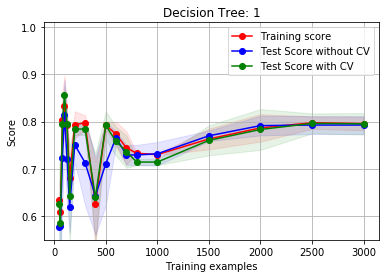

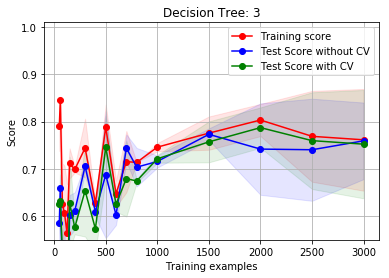

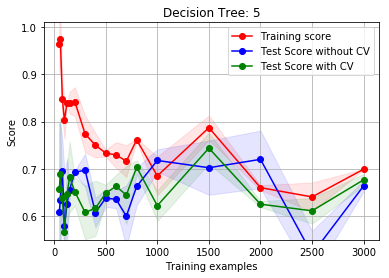

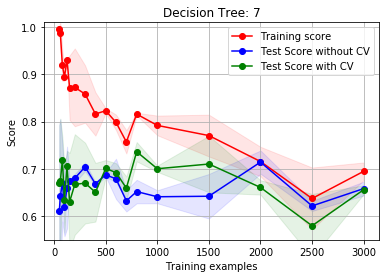

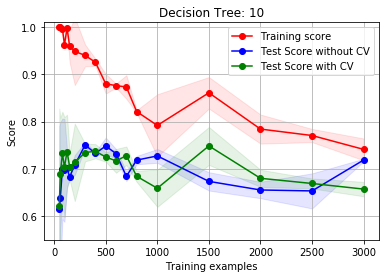

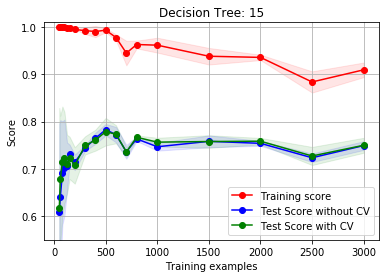

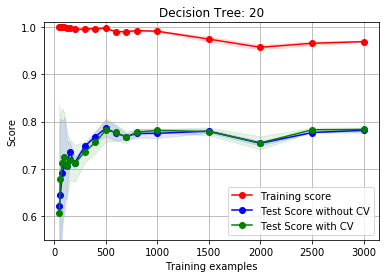

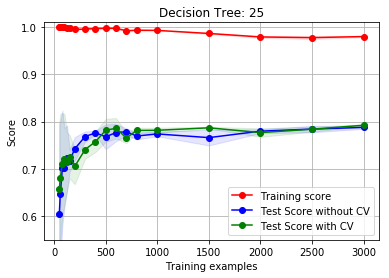

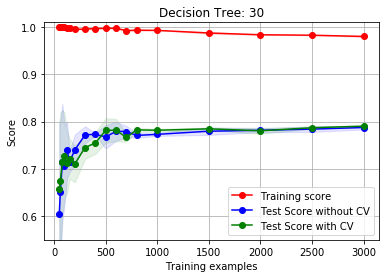

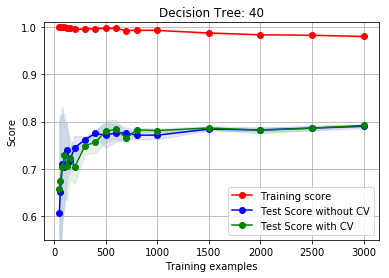

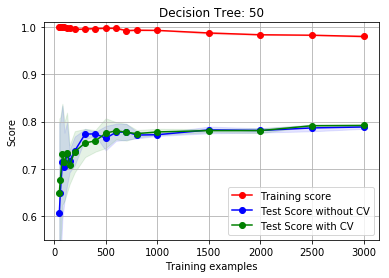

In [78]:
# Decision Tree
params = { 'criterion':['gini','entropy'] }

for i in [1, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]: 
    clf = tree.DecisionTreeClassifier(max_depth=i, class_weight='balanced', splitter='best', min_samples_leaf=1)
    output, output_clf, table_output = crossValidateAndTest('Decision Tree: ' + str(i), clf, params, trainTest)
    tree_size = output.tree_.node_count
    print('{} & {} & {} & '.format(i, output_clf.best_params_['criterion'], tree_size) + table_output + ' \\\\ \\hline') 
    
    print()
#     clf = clf.fit(X_train, y_train)

#     y_predict = clf.predict(X_test)
#     scores = cross_val_score(clf, X, y)
#     print(str(i) + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))
#     dot_data = tree.export_graphviz(clf, out_file=None, 
#                          feature_names=df_x,  
#                          class_names=classifed_names,  
#                          filled=True, rounded=True,  
#                          special_characters=True)  
#     graph = graphviz.Source(dot_data).view()

Name: Adaboost: 1
Train time: 10.422708
Train score: 0.871252741896
Test time: 0.029362
Test score: 0.870065789474
Best params: {'n_estimators': 150}
Name: Adaboost: 3
Train time: 16.122902
Train score: 0.871740190105
Test time: 0.002095
Test score: 0.873355263158
Best params: {'n_estimators': 5}
Name: Adaboost: 5


KeyboardInterrupt: 

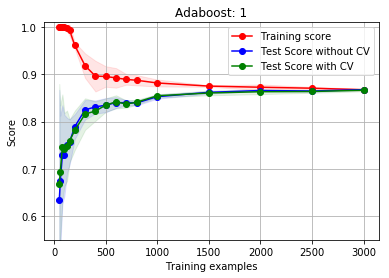

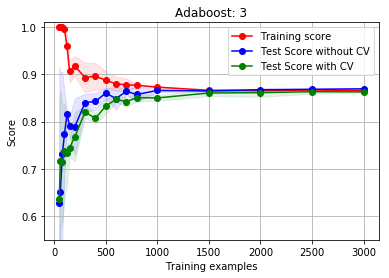

In [69]:
from sklearn.ensemble import AdaBoostClassifier
estimators = [1, 3, 5, 15, 50, 100, 150]

for i in [1, 3, 5, 10, 15, 20]: 
    clf_base = tree.DecisionTreeClassifier(max_depth=i, criterion='gini', splitter='best')
    clf = AdaBoostClassifier(base_estimator=clf_base)
    crossValidateAndTest('Adaboost: ' + str(i), clf, {'n_estimators': estimators}, trainTest)

# for estimator in estimators:
#     clf = AdaBoostClassifier(n_estimators=estimator)
    
#     crossValidateAndTest('Adaboost: ' + str(estimator), clf, {}, trainTest)
    
#     clf = clf.fit(X_train, y_train)

#     y_predict = clf.predict(X_test)
#     scores = cross_val_score(clf, X, y)
#     print(str(estimator) + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler  


alphas = np.linspace(0.001, 10, 8)
activations = ['relu', 'logistic']
layers = []

for i in [1, 5, 15, 25, 30, 40]:
    for j in [1, 2, 3, 5]:
        layers.append((i, j))

params = { 'alpha': alphas, 'activation': activations, 'hidden_layer_sizes': layers}
clf = MLPClassifier(solver='sgd', max_iter=2000, random_state=7, batch_size='auto', early_stopping=False)

crossValidateAndTest('NN', clf, params, trainTest, StandardScaler())


# for iteration_count in iterations:
#     for layer_size_1 in layer_sizes_1:
#         for layer_size_2 in layer_sizes_2:
#             clf = MLPClassifier(solver='sgd', activation='relu', max_iter=iteration_count, alpha=0.001, batch_size=200, hidden_layer_sizes=(layer_size_1, layer_size_2), random_state=42)
#             scaler.fit(X_train) 

#             X_train_new = scaler.transform(X_train)
#             X_test_new = scaler.transform(X_test)
#             clf.fit(X_train_new, y_train)
#             y_predict = clf.predict(X_test_new)
#             print(str(iteration_count) + ':' + str((layer_size_1, layer_size_2)) + ': ' + str(accuracy_score(y_test, y_predict)))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn import datasets

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)
    X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 1000

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(verbose=0, random_state=0,
                            max_iter=max_iter, **param)
        mlp.fit(X, y)
        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
    for mlp, label, args in zip(mlps, labels, plot_args):
            ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# load / generate some toy datasets

plot_on_dataset(X, y, axes.ravel()[0], 'Test')

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best params
{}


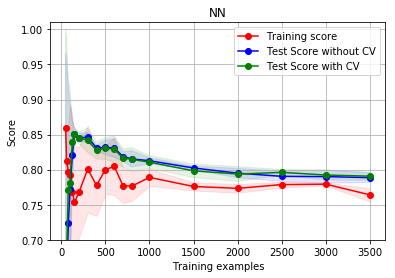

/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Best params
{}


/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/Users/philip/miniconda3/lib/python3.6/site-packages/sklearn/svm/base.py:218: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


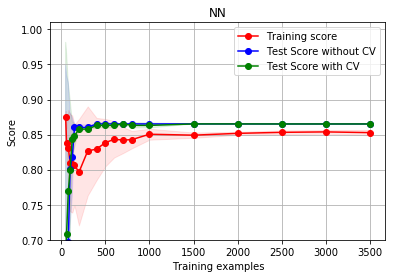

In [11]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler  

clf_1 = svm.SVC(kernel='sigmoid', max_iter=5000)
crossValidateAndTest('SVC1', clf_1, {}, trainTest, StandardScaler())

clf_2 = svm.SVC(kernel='linear', max_iter=5000)
crossValidateAndTest('SVC2', clf_2, {}, trainTest, StandardScaler())


Running knn
Best params
{'weights': 'uniform'}


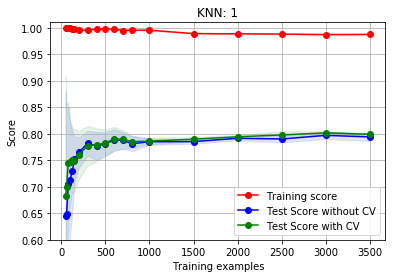

Best params
{'weights': 'distance'}


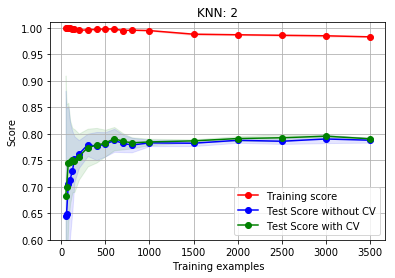

Best params
{'weights': 'uniform'}


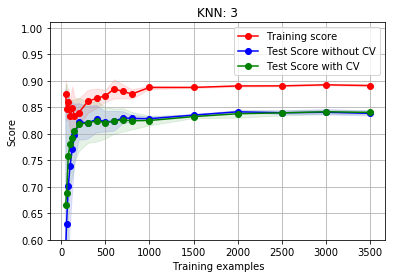

Best params
{'weights': 'distance'}


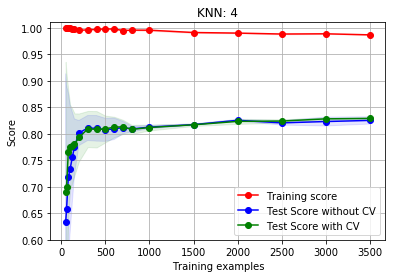

Best params
{'weights': 'uniform'}


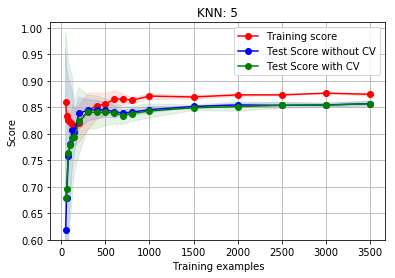

Best params
{'weights': 'uniform'}


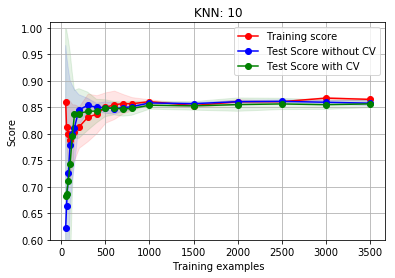

Best params
{'weights': 'uniform'}


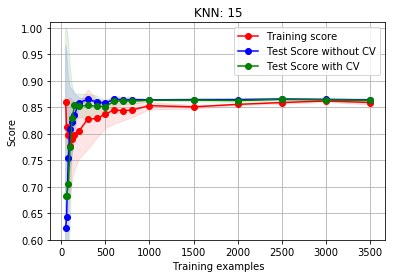

Best params
{'weights': 'uniform'}


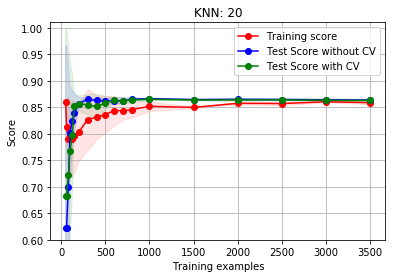

Best params
{'weights': 'uniform'}


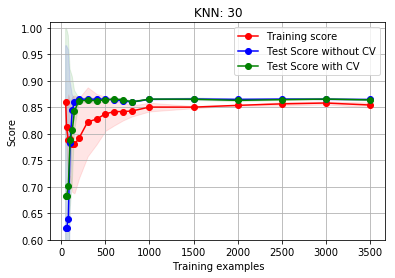

Best params
{'weights': 'uniform'}


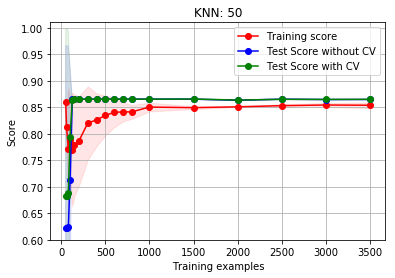

In [19]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

print('Running knn')
h = .02  # step size in the mesh

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

k_vals = [1, 2, 3, 4, 5, 10, 15, 20, 30, 50]
 
for k in k_vals:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(k)
    crossValidateAndTest('KNN: ' + str(k), clf, {'weights': ['uniform', 'distance']}, trainTest)

        
#         clf.fit(X_train, y_train)
        
#         y_predict = clf.predict(X_test)
#         scores = cross_val_score(clf, X, y)
#         print(str(k) + ':' + weight + ': ' + str(accuracy_score(y_test, y_predict)) + '   |   ' + str(scores.mean()))
